# Working with OPERA Dynamic Surface Water Extent (DSWx) Data

 Authored by Nicholas Tarpinian, *PO.DAAC*

### Notebook showcasing how to work with OPERA DSWx data
- Utilizing the Common Metadata Repository (CMR) to search and download data locally.
- Option to query the new dataset based on users choice; either by classified layer 'B01' or sensor ('L8_30_v1.0_B01_WTR'), etc.
- Visualizing the dataset based on its classified layer values.
- Mosaicking multiple layers into a single GeoTIFF file.

### Import libraries

In [1]:
import requests
import json
import rasterio as rio
from rasterio.plot import show
from rasterio.merge import merge
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np
from pathlib import Path
import os
from urllib.request import urlretrieve
from json import dumps

## Before you start

Before you beginning this tutorial, make sure you have an account in the Earthdata Login, which is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register for an Earthdata Login account. It is free to create and only takes a moment to set up.

You will also need a netrc file containing your NASA Earthdata Login credentials in order to execute this notebook. A netrc file can be created manually within text editor and saved to your home directory. For additional information see: [Authentication for NASA Earthdata](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/04_NASA_Earthdata_Authentication.html#authentication-via-netrc-file) 

In this notebook, we will be calling the authentication in the below cell, a work around if you do not yet have a netrc file.

In [2]:
from urllib import request
from http.cookiejar import CookieJar
from getpass import getpass
import netrc
from platform import system
from os.path import join, isfile, basename, abspath, expanduser

def setup_earthdata_login_auth(endpoint: str='urs.earthdata.nasa.gov'):
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        print('Please provide your Earthdata Login credentials for access.')
        print('Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass('Password: ')
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)
    
setup_earthdata_login_auth('urs.earthdata.nasa.gov')

Please provide your Earthdata Login credentials for access.
Your info will only be passed to urs.earthdata.nasa.gov and will not be exposed in Jupyter.


### Search Common Metadata Repository (CMR) for OPERA DSWx
Each dataset has it's own unique collection ID. For the OPERA_L3_DSWX-HLS_PROVISIONAL_V1 dataset, we can find the collection ID [here](https://podaac.jpl.nasa.gov/dataset/OPERA_L3_DSWX-HLS_PROVISIONAL_V1).

For this tutorial, we are looking at the Lake Powell Reservoir.

Using [bbox finder](http://bboxfinder.com/) to get the exact coordinates for our area of interest.

We will look at two different example temporal ranges; 04/11/2023 and 05/02/2023.

In [3]:
# the URL of the CMR service
cmr_url = 'https://cmr.earthdata.nasa.gov/search/granules.json'

#used to define parameters such as the concept-id, temporal and bounding box searches
parameters = {'collection_concept_id':'C2617126679-POCLOUD',
             'temporal': '2023-04-11T00:00:00Z,2023-04-11T23:59:59Z',
             #'temporal': '2023-05-02T00:00:00Z,2023-05-02T23:59:59Z',
             'bounding_box':"-111.144811,36.980121,-110.250799,37.915625", #could also use a bounding box
             'page_size':2000} #default will only return 10 granules, so we set it to the max

#request the granules from this collection
response = requests.post(cmr_url, params=parameters)

if len(response.json()['feed']['entry'])>0:
    print(len(response.json()['feed']['entry'])) #print out number of files found
    # print(dumps(response.json()['feed']['entry'][0], indent=2)) #print out the first file information

4


### Get Download links from CMR search results

In this section, you can query the dataset based on a specific classified layer 'B01' or sensor ('L8_30_v1.0_B01_WTR'), etc.

OPERA has 10 different available layers. We will look at 'B01_WTR' which is the Water Classification (WTR) layer of the OPERA DSWx dataset.

Details on each available layer and the data product can be found [here](https://d2pn8kiwq2w21t.cloudfront.net/documents/ProductSpec_DSWX_URS309746.pdf).

In [4]:
downloads = []
for r in response.json()['feed']['entry']:
    for l in r['links']:
        if 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/' in l['href']:
            if 'B01_WTR' in l['href']: #Specify which specific layer you would like to download. If not, comment out line to download the whole collection.
                downloads.append(l['href'])
print(len(downloads))

4


### Download the Data into a folder

Since we are looking at two seperate temporal ranges. Create two folder path names based on its respective time range.

In [5]:
#Create folder to house downloaded data 
folder = Path("/path/to/directory/OPERA_041123")
#folder = Path("/path/to/directory/OPERA_050223")
if not os.path.exists(folder):
    os.makedirs(folder)

In [6]:
for f in downloads:
    urlretrieve(f, f"{folder}/{os.path.basename(f)}")

### Visualizing the Dataset

Let's now visualize an individual layer that was downloaded using Rasterio to read the GeoTIFF image.

In [7]:
dsw = rio.open('/path/to/directory/OPERA_041123/OPERA_L3_DSWx-HLS_T12SVG_20230411T180222Z_20230414T030945Z_L8_30_v1.0_B01_WTR.tif')

OPERA is a single band image with specific classified rgb values.

This requires to read the single band, then creating a numpy array of the specified rgb values. e.g. 'variable'.colormap

In [8]:
image = dsw.read(1)
color_array = np.asarray(
    [dsw.colormap(1)[i] for i in range(256)], dtype=np.uint8)
dsw2 = color_array[image]

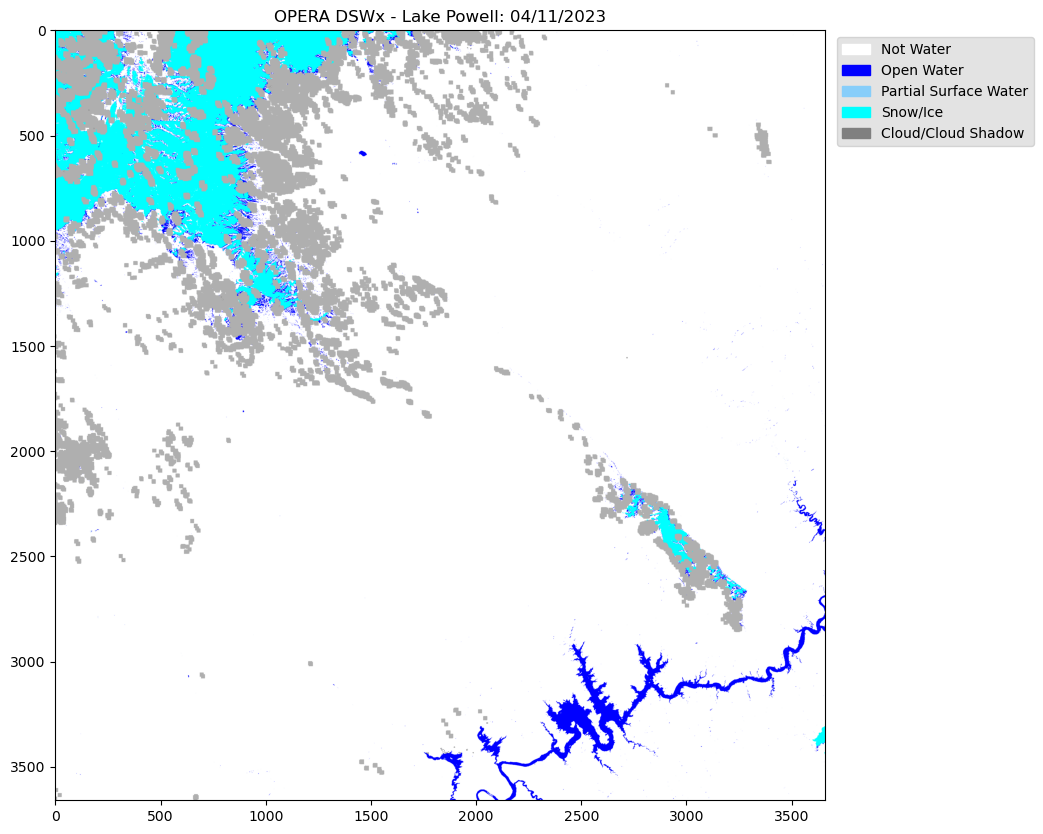

In [9]:
fig, ax = plt.subplots(figsize=(15,10))
plt.title("OPERA DSWx - Lake Powell: 04/11/2023")

#Legend based on specifed classified layer.
legend_labels = {"white":"Not Water", "blue":"Open Water", "lightskyblue":"Partial Surface Water", "cyan":"Snow/Ice", "grey":"Cloud/Cloud Shadow"}
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]
ax.legend(handles=patches,
          bbox_to_anchor=(1.28, 1),
          facecolor="gainsboro")

plt.imshow(dsw2)
plt.show()

### Mosaic Multiple OPERA Layers

When creating a mosaic, make sure the temporal range is correct/matching.

Setting the path to the folder created to download the layers based on its temporal range. Then setting an output path for the created raster mosaic GeoTIFF.

Mosaic is being created because we got 4 results due to the bounding box area provided. If you receive more than 1 result and would like to see a single raster image of all the results, mosaicking is the solution.

In [10]:
# path = Path(folder)
path = Path("/path/to/downloaded/directory/OPERA_041123")
# path = Path("/path/to/downloaded/directory/OPERA_050223")
Path('output').mkdir(parents=True, exist_ok=True)
output_path = '/path/to/output/mosaic/directory/mosaic_output_041123.tif'
# output_path = '/path/to/output/mosaic/directory/mosaic_output_050223.tif'

Looping through the folder path, which will be added to an empty list for the mosaic.

In [12]:
raster_files = list(path.iterdir())
raster_to_mosiac = []

The list created will be used to append/set the images that will be used to mosaic the raster image.

In [13]:
for p in raster_files:
    raster = rio.open(p)
    raster_to_mosiac.append(raster)

The merge function will mosaic the raster images.

In [15]:
mosaic, output = merge(raster_to_mosiac)

Then updating the raster's metadata to match the width and height of the mosaic.

In [16]:
output_meta = raster.meta.copy()
output_meta.update(
    {"driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": output
    }
)

Then you will save/write the new mosaicked raster image.

In [17]:
with rio.open(output_path, 'w', **output_meta) as m:
    m.write(mosaic)

### Visualizing the Mosaic

Open the new mosaicked raster images individually with its respective paths.

In [18]:
mos = rio.open('/path/to/output/mosaic/directory/mosaic_output_041123.tif')

In [19]:
mos1 = rio.open('/path/to/output/mosaic/directory/mosaic_output_050223.tif')

To visualize the mosaic, you must utilize the single layer colormap.

This will be the 'dsw' variable used earlier to visualize a single layer. Similarly reading the single band, then creating a numpy array of the specified rgb values. e.g. 'variable'.colormap

In [20]:
image2 = mos1.read(1)
color_array = np.asarray(
    [dsw.colormap(1)[i] for i in range(256)], dtype=np.uint8)
dsw4 = color_array[image2]

In [21]:
image1 = mos.read(1)
color_array = np.asarray(
    [dsw.colormap(1)[i] for i in range(256)], dtype=np.uint8)
dsw3 = color_array[image1]

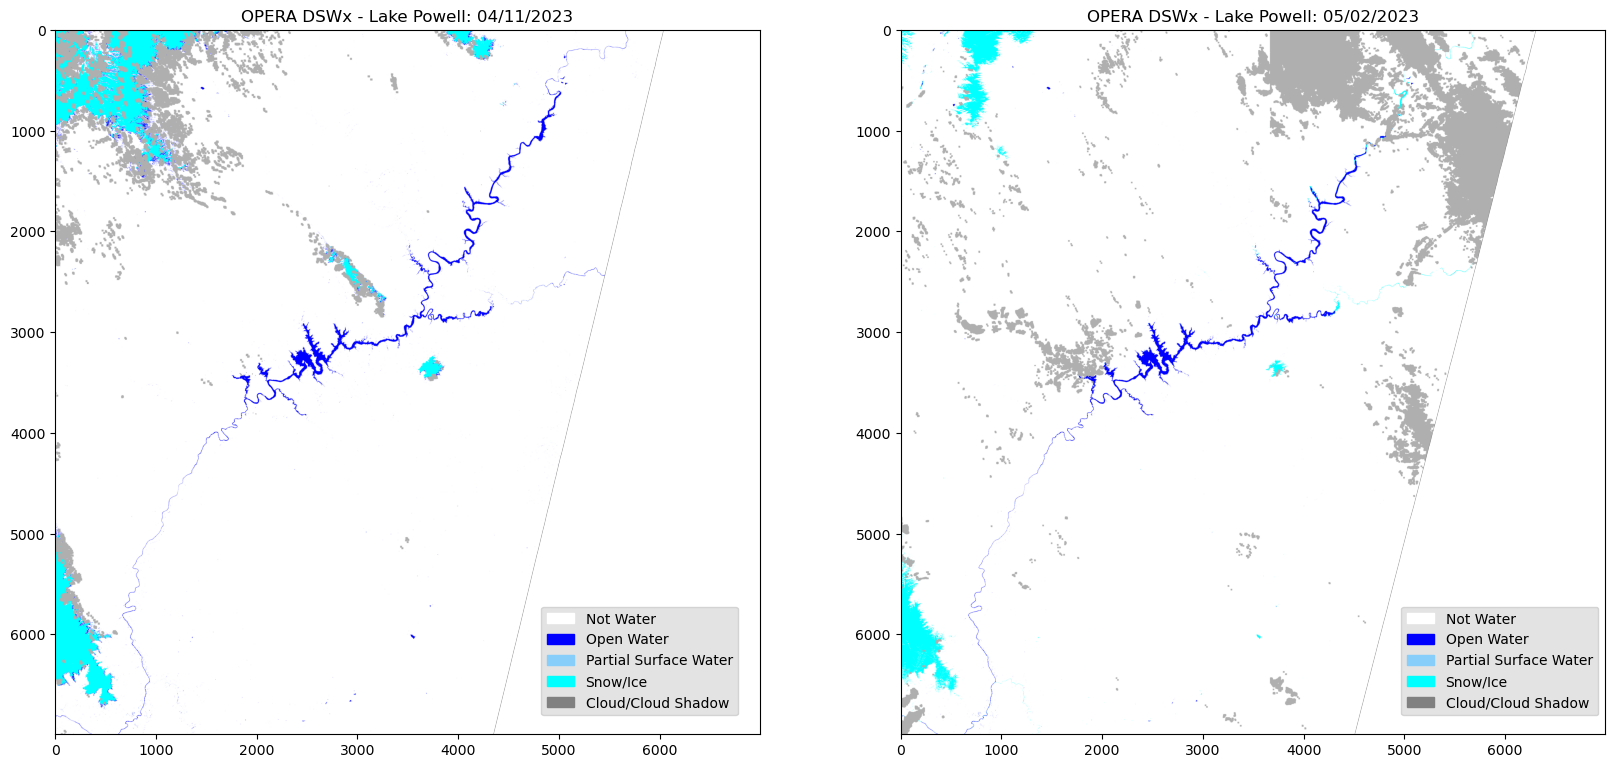

In [22]:
fig = plt.figure(figsize=(20, 15))

rows = 1
columns = 2

# Lake Powell 04/11/2023
fig.add_subplot(rows, columns, 1)
plt.title("OPERA DSWx - Lake Powell: 04/11/2023")
plt.imshow(dsw3)

#Legend based on specifed classified layer.
legend_labels = {"white":"Not Water", "blue":"Open Water", "lightskyblue":"Partial Surface Water", "cyan":"Snow/Ice", "grey":"Cloud/Cloud Shadow"}
patches = [Patch(color=color, label=label)
        for color, label in legend_labels.items()]
fig.legend(handles=patches,
        bbox_to_anchor=(0.47,0.35),
        facecolor="gainsboro")

# Lake Powell 05/02/2023
fig.add_subplot(rows, columns, 2)
plt.title("OPERA DSWx - Lake Powell: 05/02/2023")
plt.imshow(dsw4)

#Legend based on specifed classified layer.
legend_labels = {"white":"Not Water", "blue":"Open Water", "lightskyblue":"Partial Surface Water", "cyan":"Snow/Ice", "grey":"Cloud/Cloud Shadow"}
patches = [Patch(color=color, label=label)
        for color, label in legend_labels.items()]
fig.legend(handles=patches,
        bbox_to_anchor=(0.9, 0.35),
        facecolor="gainsboro")

plt.show()

### To take a closer look at a specific area of the image, we can create an inset map of a specified area.

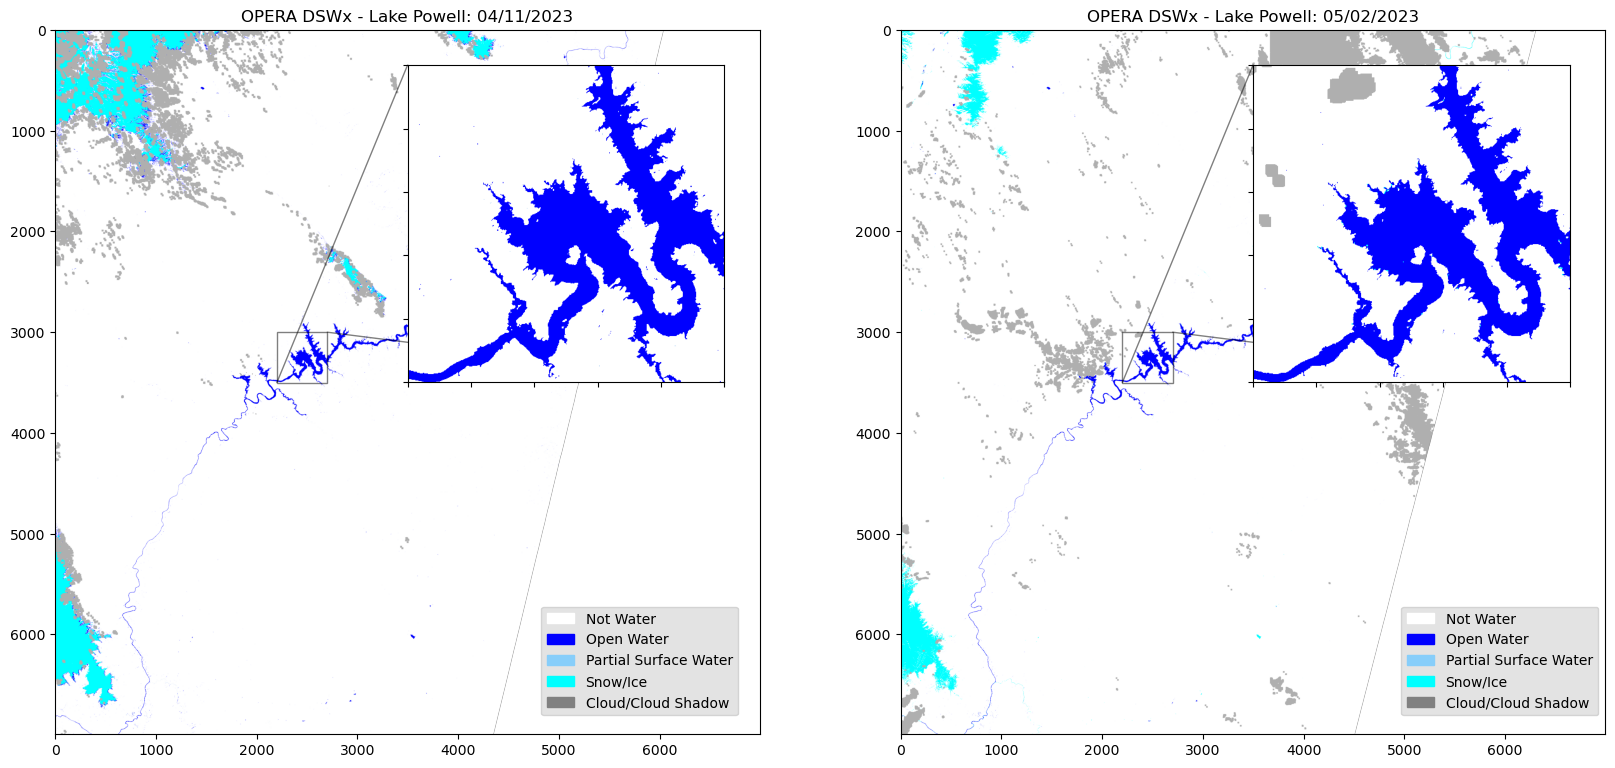

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20, 15))

ax[0].imshow(dsw3)
ax[0].set_title("OPERA DSWx - Lake Powell: 04/11/2023")

legend_labels = {"white":"Not Water", "blue":"Open Water", "lightskyblue":"Partial Surface Water", "cyan":"Snow/Ice", "grey":"Cloud/Cloud Shadow"}
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]
fig.legend(handles=patches,
          bbox_to_anchor=(0.47,0.35),
          facecolor="gainsboro")

ax_ins1 = ax[0].inset_axes([0.5, 0.5, 0.45, 0.45])
ax_ins1.imshow(dsw3)

x1, x2, y1, y2 = 2200, 2700, 3500, 3000 #Extent set for aoi of inset map.
ax_ins1.set_xlim(x1, x2)
ax_ins1.set_ylim(y1, y2)
ax_ins1.set_xticklabels('')
ax_ins1.set_yticklabels('')

ax[0].indicate_inset_zoom(ax_ins1, edgecolor='black')

ax[1].imshow(dsw4)
ax[1].set_title("OPERA DSWx - Lake Powell: 05/02/2023")

legend_labels = {"white":"Not Water", "blue":"Open Water", "lightskyblue":"Partial Surface Water", "cyan":"Snow/Ice", "grey":"Cloud/Cloud Shadow"}
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]
fig.legend(handles=patches,
          bbox_to_anchor=(0.9, 0.35),
          facecolor="gainsboro")

ax_ins2 = ax[1].inset_axes([0.5, 0.5, 0.45, 0.45])
ax_ins2.imshow(dsw4)

x1, x2, y1, y2 = 2200, 2700, 3500, 3000 #Extent set for aoi of inset map.
ax_ins2.set_xlim(x1, x2)
ax_ins2.set_ylim(y1, y2)
ax_ins2.set_xticklabels('')
ax_ins2.set_yticklabels('')

ax[1].indicate_inset_zoom(ax_ins2, edgecolor='black')

plt.show()
